# Library

In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import time
from tqdm import tqdm_notebook
from scipy.stats import ks_2samp

plt.style.use('seaborn')
sns.set(font_scale=1)

['sample_submission.csv', 'test.csv', 'train.csv']


# real_samples or synthetic_samples

In [2]:
# from https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split
test_path = '../input/test.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in tqdm_notebook(range(df_test.shape[1])):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))


100000
100000


# Load Data

In [3]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

# Quick EDA

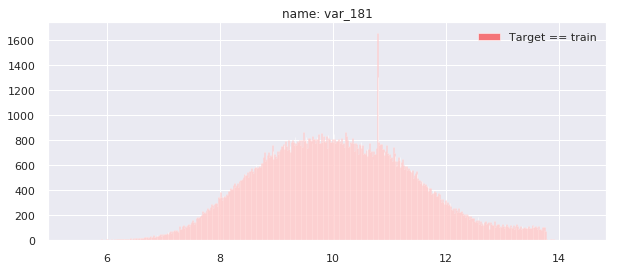

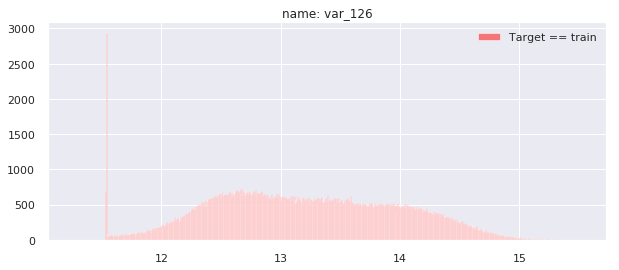

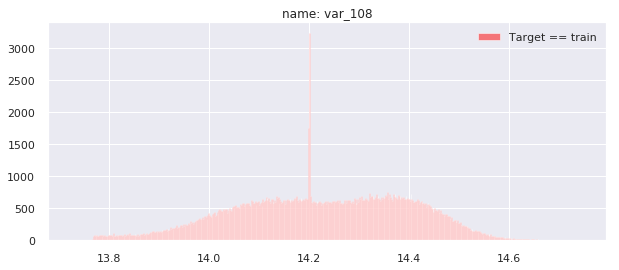

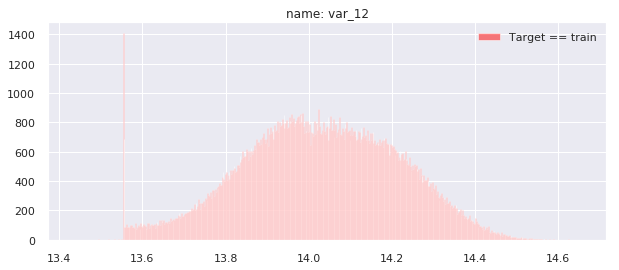

In [4]:
for var in ["var_181", "var_126", "var_108", "var_12"]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    aux = df_train.loc[:,var]
    bins = np.linspace(aux.min(), aux.max(), 600)
    plt.hist(aux, bins, alpha=0.5, label='Target == train', color="red")
    plt.legend()
    ax.set_title('name: {}'.format(var))
    plt.show()

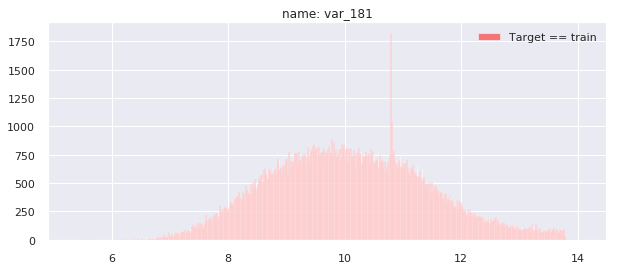

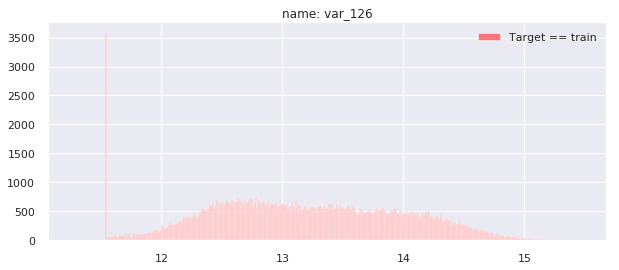

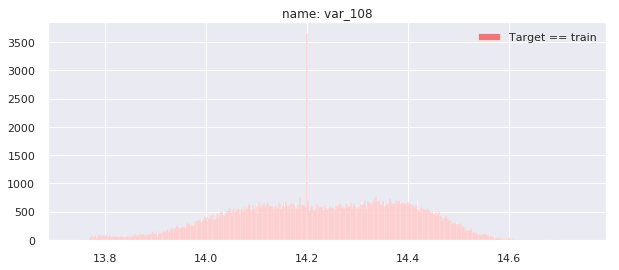

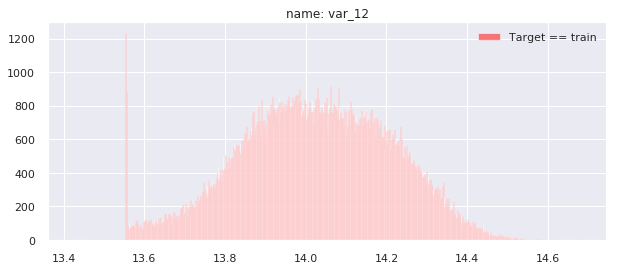

In [5]:
for var in ["var_181", "var_126", "var_108", "var_12"]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    aux = df_test.loc[:,var]
    bins = np.linspace(aux.min(), aux.max(), 600)
    plt.hist(aux, bins, alpha=0.5, label='Target == train', color="red")
    plt.legend()
    ax.set_title('name: {}'.format(var))
    plt.show()

# New feature

In [6]:
# Without this code, you will overfitting
data = pd.concat([df_train, df_test.iloc[real_samples_indexes]])
data["is_train"] = 0
data.iloc[:200000]["is_train"] = 1
# Binning
#for col in tqdm_notebook([col for col in df_test.columns if 'var' in col]):
for col in tqdm_notebook(["var_181", "var_126", "var_108", "var_12"]):
    data[col] = pd.cut(data[col], 600)

In [7]:
# COUNT
for col in tqdm_notebook([col for col in df_test.columns if 'var' in col]):
    concat = data.groupby([col], as_index=False)['ID_code'].count()
    concat = pd.DataFrame(concat).rename(columns={'ID_code': col+'_COUNT'})
    data = data.merge(concat, on=[col], how='left')

In [8]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [9]:
for col in tqdm_notebook([col for col in data.columns if 'COUNT' in col]):
    df_train[col] = data.loc[data.is_train==1, col]
    df_test = df_test.merge(data.loc[data.is_train==0, ["ID_code", col]], on="ID_code", how="left")

In [10]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [11]:
def match_columns(train, test):
    # Align the training and testing data, keep only columns present in both dataframes
    train, test = train.align(test, join = 'inner', axis=1)
    match_columns = train.columns
    
    return match_columns

def ks_sampling(train, test, threshold=0.1):
    columns = match_columns(train, test)
    train = train[columns]
    test = test[columns]
    list_p_value = []
    for i in train.columns:
        list_p_value.append(ks_2samp(test[i] , train[i])[1])
    Se = pd.Series(list_p_value, index = train.columns).sort_values() 
    list_discarded = list(Se[Se < threshold].index)
    
    return list_discarded

In [12]:
FEATS_EXCLUDED = ks_sampling(df_train.drop('ID_code', axis=1), 
                             df_test.drop('ID_code', axis=1).iloc[real_samples_indexes],
                             threshold=0.05)
FEATS_EXCLUDED

['var_90',
 'var_161',
 'var_169_COUNT',
 'var_100',
 'var_88',
 'var_82',
 'var_72',
 'var_95',
 'var_160']

In [13]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 12,
    "learning_rate" : 0.01,
    "bagging_freq": 4,
    "bagging_fraction" : 0.31740068602771787,
    "feature_fraction" : 0.028775200160257763,
    "min_data_in_leaf": 85,
    "min_sum_heassian_in_leaf": 20,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
oof = df_train[['ID_code', 'target']]
oof['predict'] = 0
predictions = df_test[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

In [15]:
features = [col for col in df_train.columns if col not in ['target', 'ID_code']]
X_test = df_test[features].values

In [16]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train, df_train['target'])):
    X_train, y_train = df_train.iloc[trn_idx][features], df_train.iloc[trn_idx]['target']
    X_valid, y_valid = df_train.iloc[val_idx][features], df_train.iloc[val_idx]['target']
    
    p_valid, yp = 0, 0
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds = 3000,
                        verbose_eval = 1000,
                        evals_result = evals_result
                       )
    
    p_valid += lgb_clf.predict(X_valid)
    yp += lgb_clf.predict(X_test)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.906979	valid_1's auc: 0.886498
[2000]	training's auc: 0.915287	valid_1's auc: 0.893054
[3000]	training's auc: 0.921718	valid_1's auc: 0.896127
[4000]	training's auc: 0.926854	valid_1's auc: 0.89814
[5000]	training's auc: 0.931523	valid_1's auc: 0.899626
[6000]	training's auc: 0.9357	valid_1's auc: 0.900421
[7000]	training's auc: 0.939661	valid_1's auc: 0.900842
[8000]	training's auc: 0.94335	valid_1's auc: 0.901152
[9000]	training's auc: 0.946864	valid_1's auc: 0.901501
[10000]	training's auc: 0.950175	valid_1's auc: 0.901562
[11000]	training's auc: 0.953318	valid_1's auc: 0.901659
[12000]	training's auc: 0.956238	valid_1's auc: 0.901661
[13000]	training's auc: 0.959148	valid_1's auc: 0.901493
[14000]	training's auc: 0.961915	valid_1's auc: 0.901257
Early stopping, best iteration is:
[11915]	training's auc: 0.955995	valid_1's auc: 0.901716
Training until validation scores don't improve for 3000 rou

In [17]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['target'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.902275369, std: 0.003133377. All auc: 0.902294303.


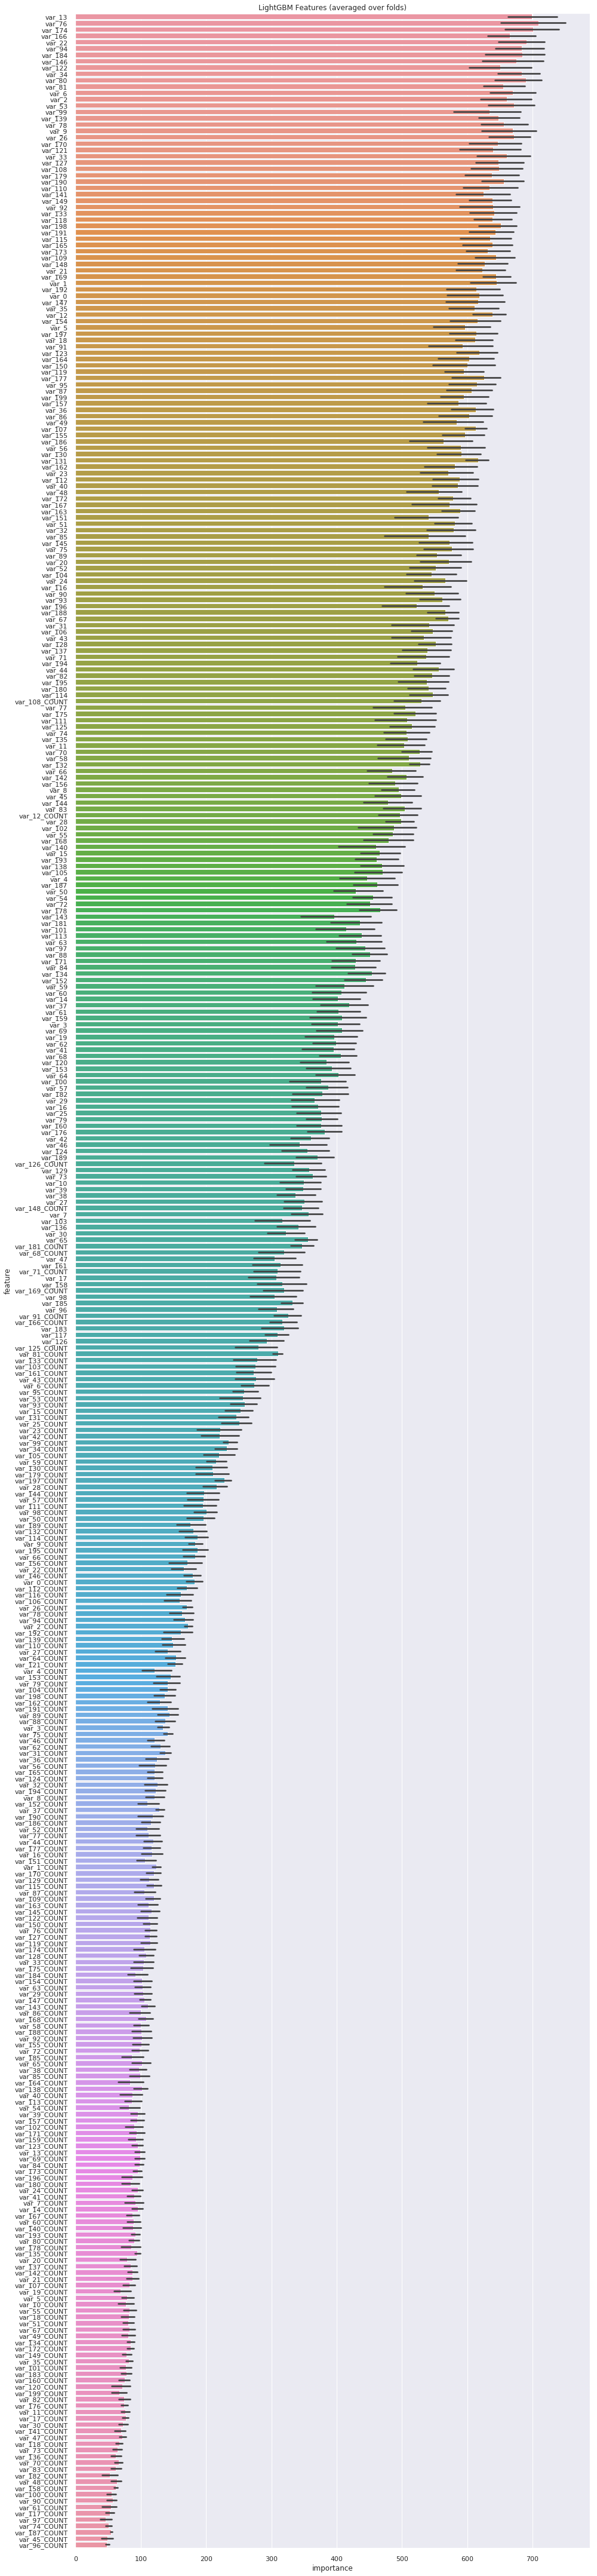

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,60))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [19]:
# submission
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('lgb_all_predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission.csv", index=False)
oof.to_csv('lgb_oof.csv', index=False)

In [20]:
sub_df.head()

,ID_code,target
0,test_0,0.241271
1,test_1,0.417203
2,test_2,0.391631
3,test_3,0.209154
4,test_4,0.136318
